<a href="https://colab.research.google.com/github/lorek/MethodsClassDimRed/blob/main/MoCaDR_List_nr_6_DecTree_AdaBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Methods of classification and dimensionality reduction**


Paweł Lorek  
University of Wrocław

# LIST NR 6: Decision Trees, AdaBoost.


 <font face="Rage" size=2  > Updated: 15.04.2025 <font>



In [ ]:


import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import time
from sklearn.datasets import make_moons
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split




### But first... linear regresssion as classifier

**Setup**: Consider a training set  $(\mathbf{x}_i, y_i), i=1,\ldots,n$ where $\mathbf{x}_i\in\mathbf{R}^d$ and $y_i\in\{-1,1\}$.

Let's look at 2D case: $\mathbf{x}_i\in \mathbf{R}^2$.
We aim to construct a simple linear classifier: for
$\mathbf{x}=(x_1,x_2)$ and $\mathbf{w}=(w_1,w_2)$
define
$$h(\mathbf{x})=\textrm{sign}(w_1x1+w_2x2+b)=\textrm{sign}(\mathbf{w}^T \mathbf{x}+b)$$

One might attempt to learn $\mathbf{w}$  and $b$  by minimizing the number of classification errors via:
$$\textrm{argmin}_{w_1,w_2,b} \sum_{i=1}^n (y_i-\textrm{sign}(\mathbf{w}^T \mathbf{x}+b))^2$$

However, this objective is problematic: the `sign` function is not differentiable, making this loss function unsuitable for gradient-based optimization.

**Key idea**:
Instead of matching the predicted **class**, we try to match the real-valued output of the model to the target label $y_i$ (i.e.,  $\mathbf{w}$ and $b$ such that $\mathbf{w}^T \mathbf{x}_i+b$ is close to "true" $y_i$). That is, we solve:
$$\textrm{argmin}_{w_1,w_2,b} \sum_{i=1}^n (y_i-(\mathbf{w}^T \mathbf{x}+b))^2.$$
This is precisely the **mean squared error** used in linear regression.
After fitting the model, classification is done by taking the sign of the predicted value:
$$h(\mathbf{x}) = \textrm{sign}(\mathbf{w}^T \mathbf{x}+b)$$



**Example** (binaly linear classifier)

Trained weights: [-0.88715005  0.2536338 ]
Trained bias: -2.4316
Classification accuracy: 91.00%


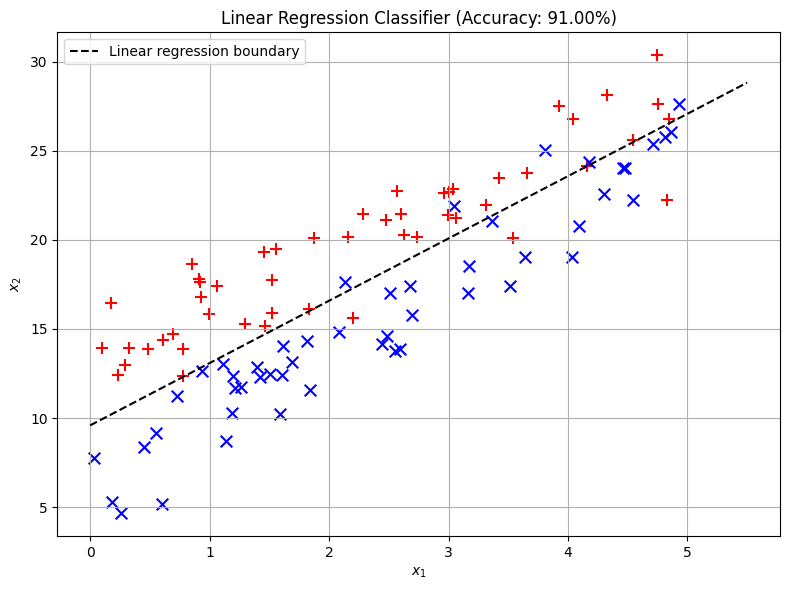

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score

# Seed for reproducibility
np.random.seed(42)

# Generate class +1: x2 = 3 * x1 + 13 + small noise
n_points = 50
x1_pos = np.random.uniform(0, 5, size=n_points)
x2_pos = 3 * x1_pos + 13 + np.random.normal(0, 2, size=n_points)
X_pos = np.stack([x1_pos, x2_pos], axis=1)
y_pos = np.ones(n_points)

# Generate class -1: x2 = 4 * x1 + 6 + small noise
x1_neg = np.random.uniform(0, 5, size=n_points)
x2_neg = 4 * x1_neg + 6 + np.random.normal(0, 2, size=n_points)
X_neg = np.stack([x1_neg, x2_neg], axis=1)
y_neg = -np.ones(n_points)

# Combine data
X = np.vstack([X_pos, X_neg])
y = np.concatenate([y_pos, y_neg])

# Fit linear regression
regressor = LinearRegression()
regressor.fit(X, y)

# Get weights and bias
w = regressor.coef_
b = regressor.intercept_
print(f"Trained weights: {w}")
print(f"Trained bias: {b:.4f}")

# Predict real values and take signs
y_pred_real = regressor.predict(X)
y_pred_sign = np.sign(y_pred_real)

# Compute accuracy
acc = accuracy_score(y, y_pred_sign)
print(f"Classification accuracy: {acc * 100:.2f}%")

# Plot data points
plt.figure(figsize=(8, 6))
for i in range(len(X)):
    color = 'red' if y[i] == 1 else 'blue'
    marker = '+' if y[i] == 1 else 'x'
    plt.scatter(X[i, 0], X[i, 1], color=color, marker=marker, s=70)

# Plot decision boundary: w1 * x1 + w2 * x2 + b = 0  =>  x2 = -(w1 * x1 + b) / w2
x_vals = np.linspace(0, 5.5, 100)
y_vals = -(w[0] * x_vals + b) / w[1]
plt.plot(x_vals, y_vals, 'k--', label='Linear regression boundary')

plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title(f'Linear Regression Classifier (Accuracy: {acc*100:.2f}%)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


**Moons dataset** (strongly non-lineary separable dataset)

Let's try to use above linear regression classifier to this dataset

In [ ]:

# some algorithms need classes {-1,+1}, other need {0,1}
# y_train01 and y_test01 are classes from {0,1}
# y_train_11 and y_test_11 are mapped classes: {-1,1}

x_train, y_train01 = make_moons(n_samples=700, noise=0.2, random_state=417)
x_test, y_test01 = make_moons(n_samples=300, noise=0.2, random_state=418)



# We want labels: -1, +1. Remap labels: 0 -> -1, 1 -> +1
y_train_11 = 2 * y_train01 - 1
y_test_11 = 2 * y_test01 - 1


x_min, x_max = x_train[:, 0].min() - 1, x_train[:, 0].max() + 1
y_min, y_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1

xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

We will use LinearRegression for classification

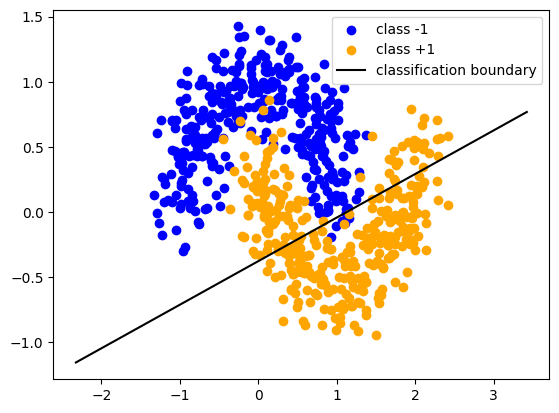

In [ ]:
regressor = LinearRegression()
regressor.fit(x_train, y_train_11)

x_grid = np.linspace(x_min, x_max, 100)


w1, w2=regressor.coef_
intercept  = regressor.intercept_

a = -w1 / w2
b = (0.5 - intercept) / w2

plt.scatter(x_train[y_train_11==-1][:, 0], x_train[y_train_11==-1][:, 1], c='blue',   label='class -1')
plt.scatter(x_train[y_train_11==1][:, 0], x_train[y_train_11==1][:, 1], c='orange', label='class +1')

plt.plot(x_grid, a*x_grid+b, color="black",label='classification boundary')
plt.legend()

plt.show()



Results quite poor:

In [ ]:
# prediction on test set, accuracy:

y_pred = regressor.predict(x_test)
# classify points based on the threshold
y_classified = np.where(y_pred > 0.5, 1, -1)
print("LSE-based classifier, ACC = ", accuracy_score(y_classified,y_test_11))

LSE-based classifier, ACC =  0.82


## Decision trees

In [ ]:
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn import tree

(play with different values of `max_depth`)

`DecisionTreeClassifier` needs classes 0,1

In [ ]:
clf_dec_tree = clf = DecisionTreeClassifier(max_depth=3) # max_depth
clf_dec_tree  = clf_dec_tree.fit(x_train,y_train01)

In [ ]:
y_dec_tree_pred = clf_dec_tree.predict(x_test)
print("DEC TREE classifier, ACC = ", accuracy_score(y_dec_tree_pred,y_test01))

DEC TREE classifier, ACC =  0.9066666666666666


### Textual and graphical representations of trees

In [ ]:
#text represantation:

text_representation = tree.export_text(clf_dec_tree)
print(text_representation)

|--- feature_1 <= 0.25
|   |--- feature_0 <= -0.40
|   |   |--- class: 0
|   |--- feature_0 >  -0.40
|   |   |--- feature_1 <= -0.01
|   |   |   |--- class: 1
|   |   |--- feature_1 >  -0.01
|   |   |   |--- class: 1
|--- feature_1 >  0.25
|   |--- feature_0 <= 1.42
|   |   |--- feature_1 <= 0.37
|   |   |   |--- class: 0
|   |   |--- feature_1 >  0.37
|   |   |   |--- class: 0
|   |--- feature_0 >  1.42
|   |   |--- class: 1



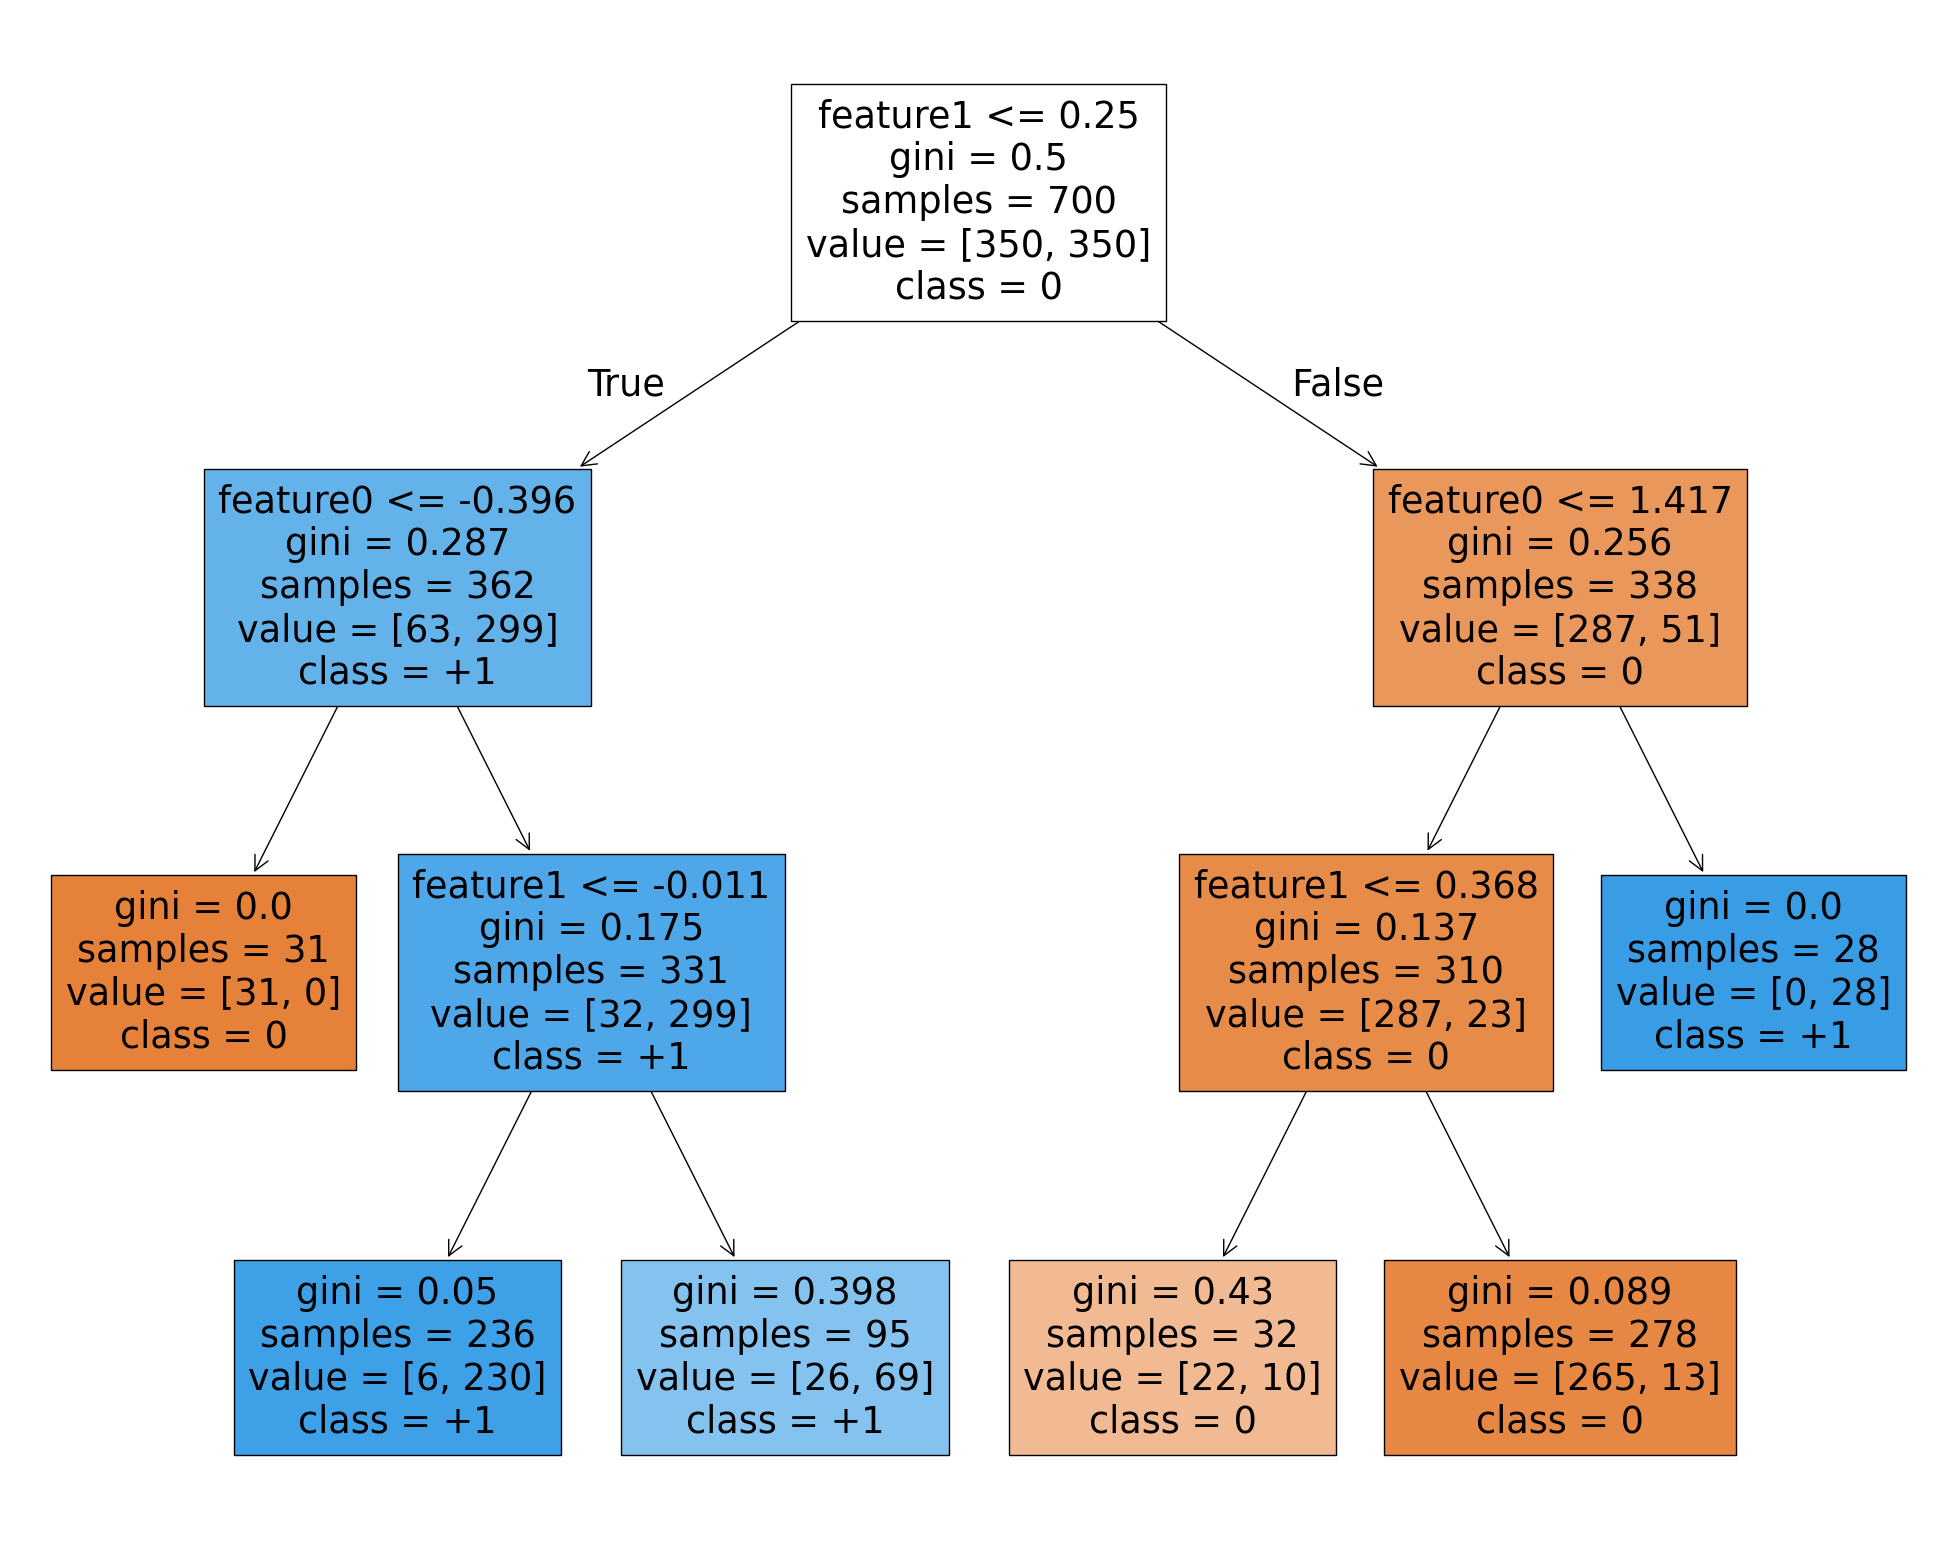

In [ ]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf_dec_tree,
                   feature_names=["feature0","feature1"],
                   class_names=["0","+1"],
                   filled=True)

### Dec tree -- Classification boundary

###A simple way to visualize decision boundaries of any classifier:

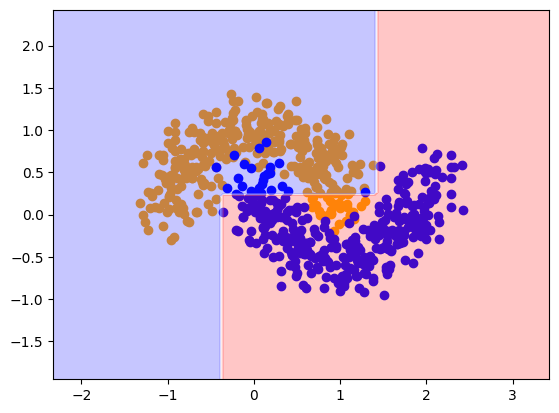

In [ ]:
plt.figure()
Z_dec = clf_dec_tree.predict(np.c_[xx.ravel(), yy.ravel()])
Z_dec = Z_dec.reshape(xx.shape)
plt.scatter(x_train[y_train01==0][:, 0], x_train[y_train01==0][:, 1], c='orange',  label='class -1')
plt.scatter(x_train[y_train01==1][:, 0], x_train[y_train01==1][:, 1], c='blue', label='class 1')
#Z_dec_plot = (Z_dec + 1) // 2  # maps -1 → 0, +1 → 1
plt.contourf(xx, yy, Z_dec,   alpha=0.26, cmap="bwr")

Now let us use a simple decision tree with `max_depth=1`

In [ ]:
clf_dec_tree = clf = DecisionTreeClassifier(max_depth=1) # max_depth
clf_dec_tree  = clf_dec_tree.fit(x_train,y_train01)


y_dec_tree_pred = clf_dec_tree.predict(x_test)
print("DEC TREE classifier, ACC = ", accuracy_score(y_dec_tree_pred,y_test01))

DEC TREE classifier, ACC =  0.8033333333333333


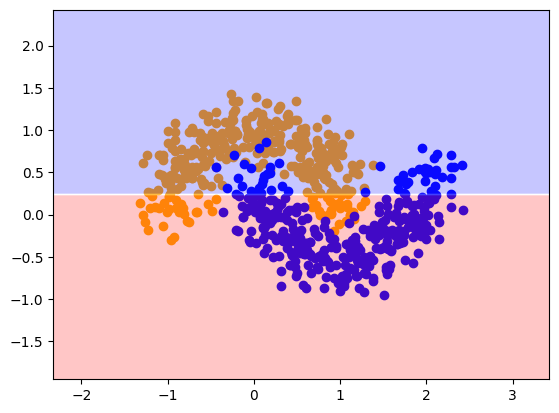

In [ ]:
# Decision boundary:
plt.figure()
Z_dec = clf_dec_tree.predict(np.c_[xx.ravel(), yy.ravel()])
Z_dec = Z_dec.reshape(xx.shape)
plt.scatter(x_train[y_train01==0][:, 0], x_train[y_train01==0][:, 1], c='orange',  label='class -1')
plt.scatter(x_train[y_train01==1][:, 0], x_train[y_train01==1][:, 1], c='blue', label='class 1')
#Z_dec_plot = (Z_dec + 1) // 2  # maps -1 → 0, +1 → 1
plt.contourf(xx, yy, Z_dec,   alpha=0.26, cmap="bwr")

## AdaBoost

We will use simple Decision Tree with `max_depth=1` in AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

In [ ]:
clf_Ada = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=60, random_state=322
)

In [ ]:
clf_Ada.fit(x_train,y_train01)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   n_estimators=60, random_state=322)

In [ ]:
y_ada_pred = clf_Ada.predict(x_test)
print("DEC TREE classifier, ACC = ", accuracy_score(y_dec_tree_pred,y_test01))
print("AdaBoost classifier, ACC = ", accuracy_score(y_ada_pred,y_test01))

DEC TREE classifier, ACC =  0.8033333333333333
AdaBoost classifier, ACC =  0.9566666666666667


### AdaBoost -- decision  boundary

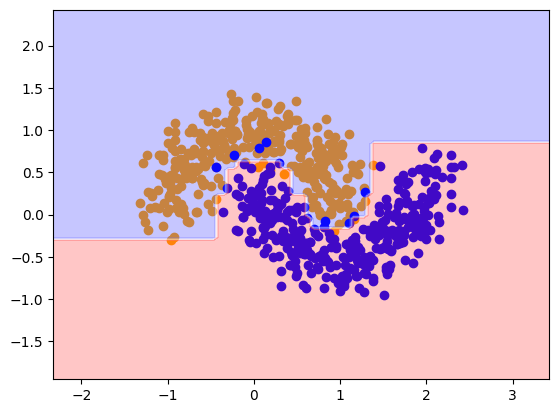

In [ ]:

Z_Ada = clf_Ada.predict(np.c_[xx.ravel(), yy.ravel()])
Z_Ada = Z_Ada.reshape(xx.shape)
plt.scatter(x_train[y_train01==0][:, 0], x_train[y_train01==0][:, 1], c='orange',  label='class 0')
plt.scatter(x_train[y_train01==1][:, 0], x_train[y_train01==1][:, 1], c='blue', label='class 1')
plt.contourf(xx, yy, Z_Ada,   alpha=0.26, cmap="bwr")


## Circular/ring data:

In [ ]:

# Set seed for reproducibility
np.random.seed(42)

def generate_circle_data(n_pos, n_neg):
    r_pos = np.random.uniform(0, 1, size=n_pos) ** 0.5  # sqrt to ensure uniform density
    theta_pos = np.random.uniform(0, 2*np.pi, size=n_pos)
    x_pos = np.stack([r_pos * np.cos(theta_pos), r_pos * np.sin(theta_pos)], axis=1)
    y_pos = np.ones(n_pos)

    r_neg = np.random.uniform(1, 3, size=n_neg) ** 0.5
    theta_neg = np.random.uniform(0, 2*np.pi, size=n_neg)
    x_neg = np.stack([r_neg * np.cos(theta_neg), r_neg * np.sin(theta_neg)], axis=1)
    y_neg = -np.ones(n_neg)

    # Combine
    X = np.vstack([x_pos, x_neg])
    y = np.concatenate([y_pos, y_neg])

    return X, y


In [ ]:
# Generate and split
X_all, y_all_11 = generate_circle_data(n_pos=400, n_neg=500)
x_train, x_test, y_train_11, y_test_11 = train_test_split(X_all, y_all_11, test_size=0.3, random_state=1)

# Create labels in {0,1} for scikit-learn classifiers
y_train01 = (y_train_11 + 1) // 2
y_test01 = (y_test_11 + 1) // 2

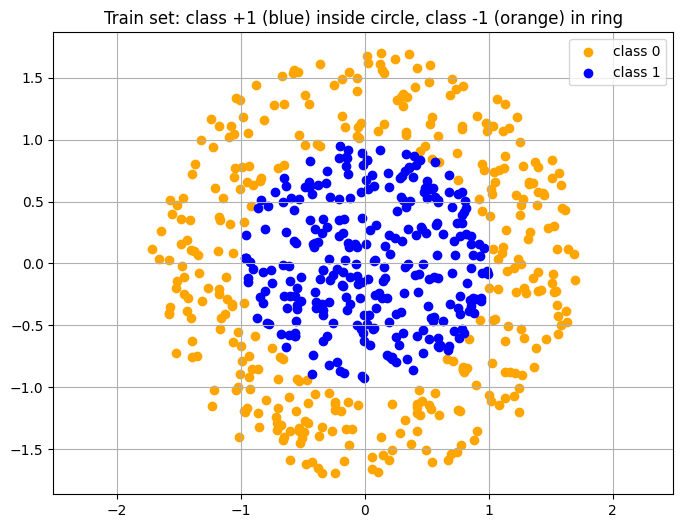

In [ ]:


# Plot
plt.figure(figsize=(8, 6))
plt.scatter(x_train[y_train01 == 0][:, 0], x_train[y_train01 == 0][:, 1], c='orange', label='class 0')
plt.scatter(x_train[y_train01 == 1][:, 0], x_train[y_train01 == 1][:, 1], c='blue', label='class 1')
plt.axis('equal')
plt.title("Train set: class +1 (blue) inside circle, class -1 (orange) in ring")
plt.legend()
plt.grid(True)
plt.show()


# Q6.1
* Apply  `DecisionTreeClassifier`   with `max_depth`$\in\{1,2,3\}$ to the circular/ring dataset. For each case, display the decision boundary and report the accuracy on the test set.
* Then, train an `AdaBoostClassifier` using 60 estimators, with each of the above decision trees as the base learner. Again, display the decision boundary and report the test accuracy for each case.

# Q6.2

**Q6.2 STARTS**

* Recall simple `Bagging` algorithm:


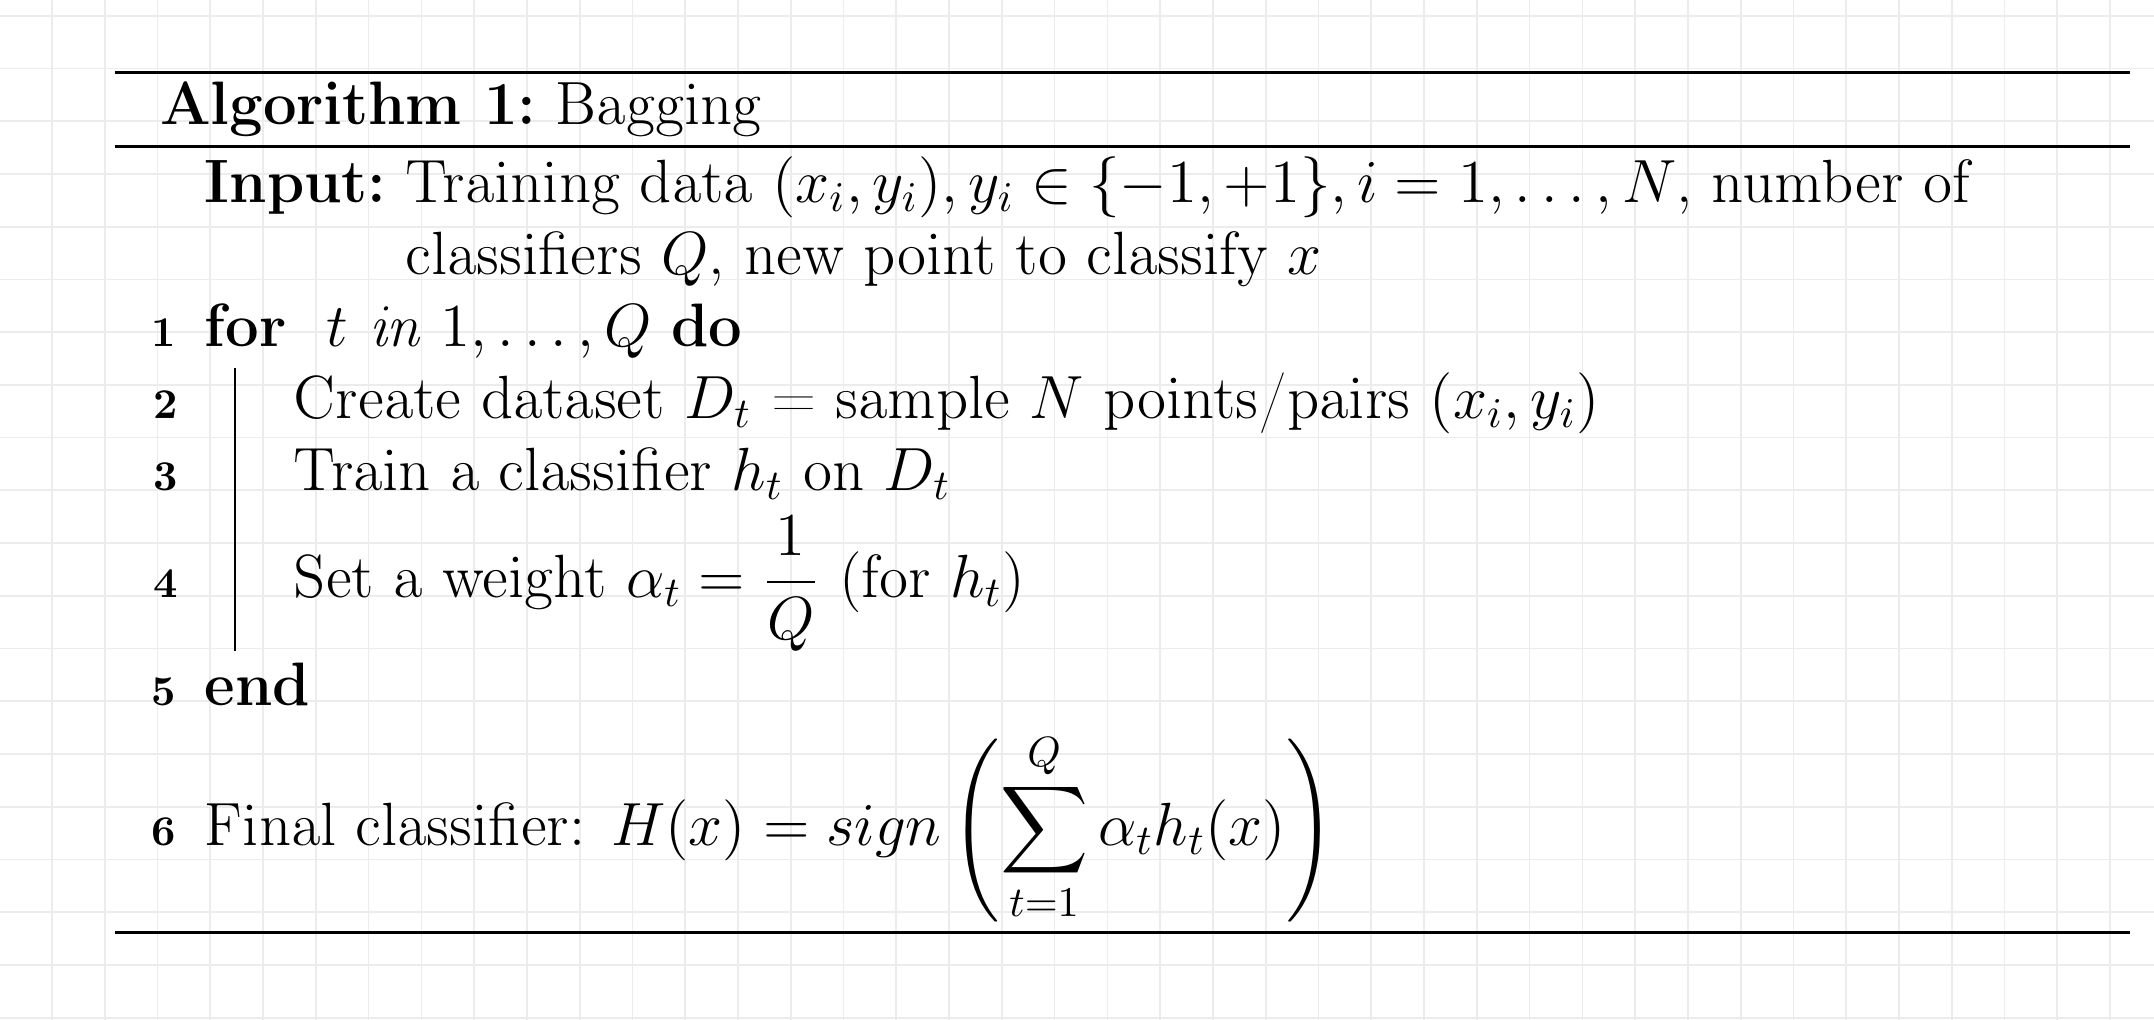

* reconsider **circular/ring dataset**:

In [ ]:

# Generate and split
X_all, y_all_11 = generate_circle_data(n_pos=400, n_neg=500)
x_train, x_test, y_train_11, y_test_11 = train_test_split(X_all, y_all_11, test_size=0.3, random_state=1)

# Create labels in {0,1} for scikit-learn classifiers
y_train01 = (y_train_11 + 1) // 2
y_test01 = (y_test_11 + 1) // 2

* **TASK** Implement above Bagging algorithm: as week classifier take `DecisionTreeClassifier` with `max_depth=3` (also, consider setting different `random_state` in each classifier). Compute final accuracy, draw decision boundary. Compare results with `AdaBoost` (for the same number of "the same" classifiers)
* Hint: you may resample (with replacemnt) e.g., this way:
```python
from sklearn.utils import resample
#
x_sample, y_sample = resample(x_train, y_train01, replace=True, n_samples=N, random_state=1000 + t)
```

**Q6.2 ENDS**

# Q6.3 Ensemble methods on the Iris DataSet
**Q6.3 STARTS**

Load and split data:


In [ ]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

X, y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


**TASK:** Train and evaluate the following classifiers:
* a) Decision Trees with depth 1, 2, and 3.
* b) Random Forest with 100 trees, each of max depth 2.
* c) AdaBoost (with 50 estimators) using the models from (a) and (b) as base estimators

For each model:
* Fit on `X_train`, predict on `X_test`.
* Print classification accuracy
* Which approach performs best?


**Q6.3 ENDS**